# Predicting Firm Sales over the next 2 years: 2012 vs 2014

In [65]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

### Helper functions (from book)

In [66]:
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]


def skew(l, round_n=3):
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )

    return plot


def poly(x, degree=1):
    """
    Fit Polynomial
    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)

### Import the dataset

In [67]:
data = pd.read_csv("fin-bisnode_firms_cleaned.csv")

In [68]:
data.year.unique()

array([2013], dtype=int64)

In [69]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,sales_mil_log_sq,ROE,ROE_target,EBITDA,ROA,sales_per_tot_assets,liquidity_rate,own_equity_rate,high_growth_firm,high_roe_firm
count,16974.0,1.697400e+04,1.697400e+04,1.697400e+04,1.697400e+04,1.697400e+04,1.697400e+04,1.697400e+04,1.697400e+04,1.697400e+04,...,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000
mean,2013.0,1.537866e+11,1.006558e+04,1.092529e+05,9.027632e+04,5.004698e+02,1.724146e+03,1.280045e+03,1.606855e+05,9.890140e+03,...,11.139780,-242.457392,-209.792432,-76.190846,-76.327570,143.253639,3857.424493,-186.158762,0.196006,0.208790
std,0.0,1.376887e+11,4.911415e+04,4.422516e+05,3.587848e+05,1.026047e+04,3.130242e+04,3.125872e+04,1.171922e+06,1.095038e+05,...,9.895148,414.512571,396.321216,1566.504241,1566.584817,2452.944059,30567.846542,3270.039628,0.396985,0.406456
min,2013.0,1.001541e+06,-1.106296e+04,0.000000e+00,-2.581481e+03,-3.703704e+03,-1.470000e+04,-3.909408e+05,0.000000e+00,-3.997896e+06,...,0.000006,-944.399992,-944.399992,-33969.999942,-33969.999942,0.000121,-462.666683,-61959.001972,0.000000,0.000000
25%,2013.0,2.929296e+10,1.555556e+02,4.066667e+03,4.229629e+03,0.000000e+00,0.000000e+00,0.000000e+00,4.444445e+02,-4.688889e+03,...,3.446678,-944.399992,-1.939799,-0.158461,-0.219616,0.773657,0.333046,-0.634737,0.000000,0.000000
50%,2013.0,1.154482e+11,1.077778e+03,1.406667e+04,1.697593e+04,0.000000e+00,0.000000e+00,0.000000e+00,6.390741e+03,6.888889e+02,...,8.727505,0.007420,0.018089,0.053841,0.019020,1.880261,1.142154,0.240544,0.000000,0.000000
75%,2013.0,2.582085e+11,4.787963e+03,4.926482e+04,5.420000e+04,0.000000e+00,0.000000e+00,0.000000e+00,5.005000e+04,6.125000e+03,...,15.901631,0.211732,0.230869,0.188407,0.126834,4.498612,2.989374,0.662615,0.000000,0.000000
max,2013.0,4.641050e+11,2.131752e+06,1.400582e+07,1.366079e+07,1.007889e+06,3.137496e+06,3.137496e+06,1.015350e+08,1.894804e+06,...,47.717083,4439.599892,5710.999944,695.272723,693.636359,46369.999055,246574.674406,97.216868,1.000000,1.000000


### Regression helper functions

In [70]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": np.asscalar(model.intercept_)},
        ignore_index=True,
    )
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot

def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot

def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_reverse(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + theme_bw()
    )
    return plot

### Define Variables

In [71]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)


hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

financial_extras = [
    "ROE",
    "EBITDA",
    "ROA",
    "sales_per_tot_assets",
    "liquidity_rate",
    "own_equity_rate",
]

In [72]:
# Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)", data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(["C(ind2_cat)[26.0]"], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)", data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(["C(m_region_loc)[Central]"], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)", data, return_type="dataframe")
urban_mmat = urban_mmat.drop(["C(urban_m)[1.0]"], axis=1)

In [73]:
# Define X1
basevars = data[
    ["sales_mil_log", "sales_mil_log_sq", "sale_growth", "profit_loss_year_pl"]
]
X1 = pd.concat([basevars, ind2_catmat], axis=1)
# Define X2
X2additional_vars = data[
    [
        "fixed_assets_bs",
        "share_eq_bs",
        "curr_liab_bs",
        "curr_liab_bs_flag_high",
        "curr_liab_bs_flag_error",
        "age",
        "foreign_management",
    ]
]
X2 = pd.concat([X1, X2additional_vars], axis=1)
# Define X3
firm = pd.concat(
    [data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1
)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar], firm], axis=1)
# Define X4
X4 = pd.concat(
    [
        data[
            ["sales_mil_log", "sales_mil_log_sq"]
            + engvar
            + engvar2
            + engvar3
            + hr
            + qualityvars
            + financial_extras
        ],
        firm,
    ],
    axis=1,
)

In [74]:
# Define X5
# Creat matrix for interactions1 variables
int1mat = patsy.dmatrix(
    "0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):sale_growth \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod",
    data,
    return_type="dataframe",
)
# Drop first level to get k-1 dummies out of k categorical levels
for col in int1mat.columns:
    if col.startswith("C(ind2_cat)[26.0]") or col.endswith("C(urban_m)[1.0]"):
        int1mat = int1mat.drop([col], axis=1)

# Creat matrix for interactions2 variables
int2mat = patsy.dmatrix(
    "0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management",
    data,
    return_type="dataframe",
)
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [75]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [76]:
# Define rfvars for RF (no interactions, no modified features)
rfvars = pd.concat([data[["sales_mil"] + rawvars + hr + qualityvars], firm], axis=1)

### Set the target

In [77]:
y = data["high_growth_firm"]
target = "high_growth_firm"

In [78]:
data[["high_growth_firm","high_roe_firm"]].corr()

,high_growth_firm,high_roe_firm
high_growth_firm,1.000000,0.171379
high_roe_firm,0.171379,1.000000


### Create train and holdout sets

In [79]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.7*len(data.index)), random_state=44)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [80]:
print('Total')
print(data[target].value_counts(normalize=True))
print('Train')
print(data.iloc[index_train][target].value_counts(normalize=True))
print('Holdout')
print(data.iloc[index_holdout][target].value_counts(normalize=True))

Total
0    0.803994
1    0.196006
Name: high_growth_firm, dtype: float64
Train
0    0.807692
1    0.192308
Name: high_growth_firm, dtype: float64
Holdout
0    0.795365
1    0.204635
Name: high_growth_firm, dtype: float64


## First Step: Predict Probabilities

In [81]:
# Specify cross-validation method

k = KFold(n_splits=5, shuffle=True, random_state=42)

### Logit model training

In [82]:
# Regularisation is not needed so setting the parameter to a high value

C_value_logit=[1e20]

In [83]:
# Train Logit Models 

logit_model_vars = [
    X1.iloc[index_train],
    X2.iloc[index_train],
    X3.iloc[index_train],
    X4.iloc[index_train],
    X5.iloc[index_train],
]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )
    logit_models["X" + str(i + 1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    
    CV_RMSE_folds["X" + str(i + 1)] = np.sqrt(
        -1 * (logit_models["X" + str(i + 1)].scores_[1])
    ).tolist()

### LASSO Logit Model

In [84]:
normalized_logitvars=pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns=logitvars.columns

In [85]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [1 / (l * n_obs) for l in lambdas]

logLasso = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="accuracy",
    solver="liblinear",
    random_state=42,
)

In [86]:
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

In [87]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.001052,0.807692
1,0.046416,0.002266,0.807692
2,0.021544,0.004883,0.807692
3,0.010000,0.010520,0.807524
4,0.004642,0.022665,0.806514
5,0.002154,0.048830,0.806346
6,0.001000,0.105201,0.806009
7,0.000464,0.226649,0.805925
8,0.000215,0.488300,0.805841
9,0.000100,1.052011,0.805251


In [88]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]

In [89]:
coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,sales_mil_log,0.000000
1,sales_mil_log_sq,0.000000
2,total_assets_bs,0.000000
3,fixed_assets_bs,0.000000
4,liq_assets_bs,0.000000
...,...,...
151,sales_mil_log:age,0.000000
152,sales_mil_log:female,0.000000
153,sales_mil_log:profit_loss_year_pl,0.000000
154,sales_mil_log:foreign_management,0.000000


In [90]:
# Refit with negative brier score so we have RMSE values for the same cv split

logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [91]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds["LASSO"] = np.sqrt(
            -1 * (logLasso_brier_fitted.scores_[1][:, i])
        ).tolist()

### No loss function

In [92]:
# Calculate AUC for each fold 

CV_AUC_folds = dict()

# Refit logit models with AUC so we have AUC values for the same cv split

for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds["X" + str(i + 1)] = LRCV_auc_fit.scores_[1][:, 0].tolist()

In [93]:
# Refit with AUC so we have AUC values for the same cv split

logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][:, best_lambda_i].tolist()

In [94]:
# For each model: average RMSE and average AUC for models 

CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])

for key in logit_models:
    if key != "LASSO":
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [95]:
# There are 6 models, (5 logit and the logit lasso). For each we have a 5-CV RMSE and AUC.
# Pick our preferred model based on these two values. 

logit_summary1 = np.transpose(
    pd.DataFrame.from_dict([nvars, CV_RMSE, CV_AUC], orient="columns")
)
logit_summary1.columns = ["Number of predictors", "CV RMSE", "CV AUC"]

In [96]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.389958,0.609884
X2,18.0,0.388679,0.619885
X3,31.0,0.388504,0.626029
X4,81.0,0.387607,0.631532
X5,155.0,0.386042,0.645150
LASSO,0.0,0.406609,0.500000


### Test the performance of the best model on the holdout set

All six models seem to perform pretty similarly, so I will go with the simpler model, simple logit X4.

In [97]:
data_train = X4.iloc[index_train]

In [98]:
best_model = logit_models["X4"]
data_train = X4.iloc[index_train]

best_model.fit(data_train,y_train)
best_model_X_holdout = X4.iloc[index_holdout]

logit_predicted_probabilities_train = best_model.predict_proba(data_train)[
    :, 1
]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[
    :, 1
]
best_rmse_holdout = np.sqrt(
    metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout)
)
round(best_rmse_holdout, 3)

0.397

In [99]:
# Discrete ROC (with thresholds in steps) on holdout 

thresholds = seq(0.01, 0.7, by=0.05)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [100]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

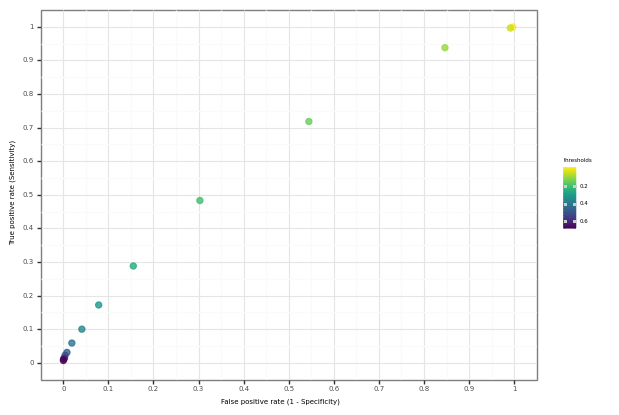

<ggplot: (103175227091)>

In [101]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=2, alpha=0.8)
    + scale_color_continuous(trans="reverse")
    + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1.01, by=0.1))
    + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1.01, by=0.1))
    + theme_bw()
    + theme(
        legend_position="right",
        axis_text=element_text(size=5),
        axis_title=element_text(size=5),
        legend_text=element_text(size=4),
        legend_title=element_text(size=4),
        legend_key_size=6,
    )
)

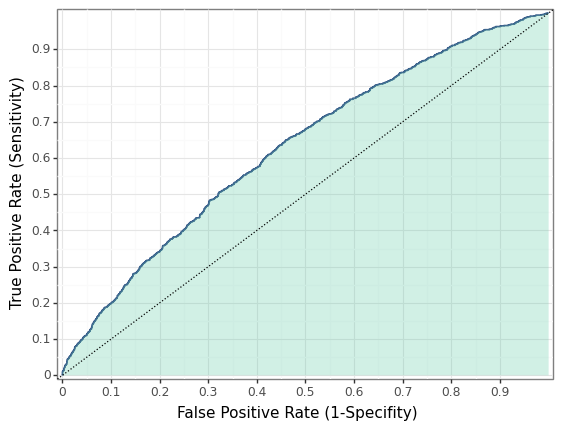

<ggplot: (103173033192)>

In [102]:
# Continuous ROC on holdout with best model (Logit 4)

create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

In [103]:
# Confusion table with different tresholds

# Default: the threshold 0.5 is used to convert probabilities to binary classes

logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " low growth: ", counts[0])
print(values[1], " high growth: ", counts[1])

0  low growth:  5048
1  high growth:  44


In [104]:
# Confusion matrix: summarize different type of errors and successfully predicted cases
# positive = "yes": explicitly specify the positive case

cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0, 1])
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual low growth", "Actual hight growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm1

,Predicted low growth,Predicted high growth
Actual low growth,4030,20
Actual hight growth,1018,24


In [105]:
# A sensible choice: mean of predicted probabilities

mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_default_prob, 3)

0.194

In [106]:
holdout_prediction = np.where(
    logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1])
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm2


,Predicted low growth,Predicted high growth
Actual low growth,2552,1498
Actual high growth,472,570


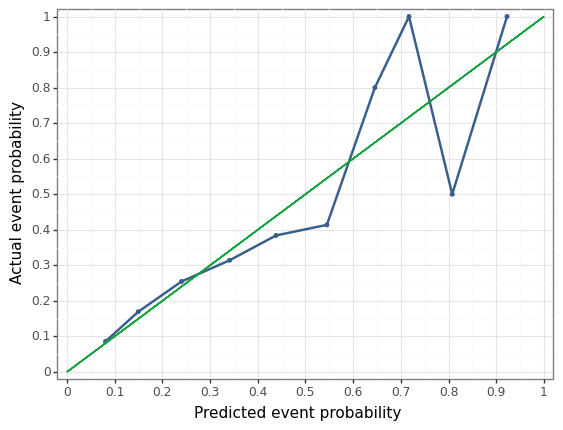

<ggplot: (103173169387)>

In [107]:
# Calibration curve -----------------------------------------------------------
# how well do estimated vs actual event probabilities relate to each other?

holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(
    holdout,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_logit_no_loss_pred",
    actual_var=target,
    y_lab="Actual event probability",
    #breaks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],
)

In [108]:
data_train = data_train.assign(
    best_logit_no_loss_pred=logit_predicted_probabilities_train, target=y_train
)

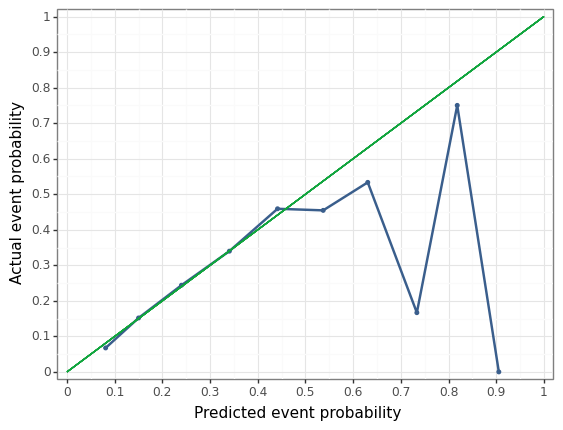

<ggplot: (103174887659)>

In [109]:
create_calibration_plot(
    data_train,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_logit_no_loss_pred",
    actual_var="target",
    y_lab="Actual event probability",
        #breaks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],
)

In [110]:
coef_matrix(best_model_X_holdout,best_model).sort_values(by=["coefficient"])

,variable,coefficient
58,balsheet_flag,-2.204270
46,inc_bef_tax_pl_flag_zero,-1.223740
60,balsheet_notfullyear,-0.808614
21,extra_exp_pl_flag_high,-0.770985
27,liq_assets_bs_flag_high,-0.752437
...,...,...
51,flag_high_ceo_age,0.646409
11,extra_profit_loss_pl,0.668481
9,extra_exp_pl,0.732838
13,inventories_pl,1.046268


In [111]:
holdout.loc[lambda x: x[target]==1,"best_logit_no_loss_pred"].mean()

0.22671060907004706

In [112]:
holdout.loc[lambda x: x[target]==0,"best_logit_no_loss_pred"].mean()

0.18502969801132527

## Random Forest Model

In [113]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

### Probabilities

Split by gini, ratio of 1's in each tree, average over trees

In [114]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
}  # 1 more than in R because here condition for min node size is >= while > in R

In [115]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(prob_forest, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [116]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [117]:
# create CV summary table
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = (
        cv_accuracy + prob_forest_fit.cv_results_["split" + str(i) + "_test_accuracy"]
    )
cv_accuracy = cv_accuracy / 5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_["split" + str(i) + "_test_roc_auc"]
cv_auc = cv_auc / 5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = (
        cv_rmse
        + np.sqrt(
            -1
            * (prob_forest_fit.cv_results_["split" + str(i) + "_test_neg_brier_score"])
        ).tolist()
    )
cv_rmse = cv_rmse / 5

prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_accuracy": cv_accuracy,
        "cv_auc": cv_auc,
        "cv_rmse": cv_rmse,
    }
)

In [118]:
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.809544,0.627311,0.387596
1,5,16,0.809460,0.627352,0.387559
2,6,11,0.808870,0.624597,0.388053
3,6,16,0.809207,0.625917,0.387816
4,7,11,0.809123,0.624331,0.388301
5,7,16,0.808871,0.626879,0.387915


In [119]:
# Obtain optimal parameter values

best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 11}

In [120]:
# Get average (ie over the folds) RMSE and AUC 

prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE["rf_p"] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC["rf_p"] = prob_forest_best_results.cv_auc.values[0]

In [121]:
# Get fold level RMSE and AUC 

CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(
        -1 * (prob_forest_fit.cv_results_["split" + str(i) + "_test_neg_brier_score"])
    ).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds["rf_p"] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_forest_fit.cv_results_["split" + str(i) + "_test_roc_auc"][
        prob_forest_best_results_index
    ]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds["rf_p"] = CV_AUC_folds_rf_p

### Comparing the performance of all models

In [122]:
#Note: in R length(rfvars) counts 1 for category variables (39), here they count category number-1 (44)

nvars['rf_p'] = len(rfvars.columns)

In [123]:
summary_results = pd.DataFrame(
    {
        "Model": list(nvars.keys()),
        "Number of predictors": list(nvars.values()),
        "CV RMSE": list(CV_RMSE.values()),
        "CV AUC": list(CV_AUC.values())
    }
)

In [124]:
summary_results.round(3)

,Model,Number of predictors,CV RMSE,CV AUC
0,X1,11,0.390,0.610
1,X2,18,0.389,0.620
2,X3,31,0.389,0.626
3,X4,81,0.388,0.632
4,X5,155,0.386,0.645
5,LASSO,0,0.407,0.500
6,rf_p,43,0.388,0.627
